# TDT13 Project - Oskar Holm (F2023)

This project is based on the shared task related to Social Media Geolocation (SMG) from VarDial 2020 and 2021, specifically the Workshop on Natural Language Processing (NLP) for Similar Languages, Varieties, and Dialects. Unlike typical VarDial tasks that involve choosing from a set of variety labels, this task focuses on predicting the latitude and longitude from which a social media post was made.

The task remained the same in both 2020 and 2021, covering three language areas: Bosnian-Croatian-Montenegrin-Serbian, German (Germany and Austria), and German-speaking Switzerland. This project is limited to the German-speaking Switzerland area due to time constraints and resource availability.

The goal of the project is to replicate the results of a study that used a BERT-based classifier for this double regression task. The dataset from the 2020 VarDial challenge is chosen because it had more submissions compared to the 2021 dataset. 

## Dependencies and Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import torch
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import json 
from transformers import AdamW
from tqdm import tqdm

from lib.scalers import scalers
from lib.train_utils import TensorBoardCheckpoint, get_model, get_lossfn, get_scheduler
from lib.geo import to_projection, GeolocationDataset, transform_to_latlon
from lib.metrics import median_distance, mean_distance
from lib.plotting import plot_switzerland, plot_barchart

data_path = '../data'
vardial_path = '../vardial-shared-tasks/SMG2020'

## Load Config and Datasets

In [3]:
config_name = 'bert-swiss-L2-reduced-dev-plateau'

with open('./configs.json', 'r') as f: 
    config = json.load(f)[config_name]

config

{'train_data': 'SMG2020/ch/train.txt',
 'dev_data': 'SMG2020/ch/dev.txt',
 'scaler': 'joint',
 'model_type': 'bert',
 'model_name': 'statworx/bert-base-german-cased-finetuned-swiss',
 'lossfn': 'L2',
 'scheduler': 'reduce_lr_on_plateau',
 'save_predictions': True,
 'train_batch_size': 32,
 'max_seq_length': 128,
 'epochs': 100,
 'lr': 2e-05,
 'seed': 42,
 'projection': 'utm',
 'zone_number': 32,
 'zone_letter': 'T',
 'split': 'reduced-dev'}

In [4]:
train_data = pd.read_table(f'{vardial_path}/ch/train.txt', header=None, names=['lat', 'lon', 'text'])
dev_data = pd.read_table(f'{vardial_path}/ch/dev.txt', header=None, names=['lat', 'lon', 'text'])
test_gold_data = pd.read_table(f'{vardial_path}/ch/test_gold.txt', header=None, names=['lat', 'lon', 'text'])

if 'split' in config and config['split'] == 'reduced-dev':
    rows_to_transfer = len(dev_data) - 1000
    transfer_data = dev_data.iloc[:rows_to_transfer]
    dev_data = dev_data.iloc[rows_to_transfer:]
    train_data = pd.concat([train_data, transfer_data])
    print(f'Train size: {len(train_data)}')
    print(f'Dev size: {len(dev_data)}')

# Convert to specified projection, if any
train_data, col_names = to_projection(train_data, config)
dev_data, _ = to_projection(dev_data, config)
test_gold_data, _ = to_projection(test_gold_data, config)

scaler = scalers[config['scaler']]()

train_coords = scaler.fit_transform(train_data[col_names[:2]].values)
train_dataset = GeolocationDataset(train_data['text'].tolist(), train_coords, config)
train_loader = DataLoader(train_dataset, batch_size=config['train_batch_size'], shuffle=True)

Path(f'{data_path}/ch').mkdir(exist_ok=True)
with open(f'{data_path}/ch/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

dev_coords = scaler.transform(dev_data[col_names[:2]].values)
dev_dataset = GeolocationDataset(dev_data['text'].tolist(), dev_coords, config)
dev_loader = DataLoader(dev_dataset, batch_size=config['train_batch_size'], shuffle=False)

test_gold_coords = scaler.transform(test_gold_data[col_names[:2]].values)
test_gold_dataset = GeolocationDataset(test_gold_data['text'].tolist(), test_gold_coords, config)
test_gold_loader = DataLoader(test_gold_dataset, batch_size=config['train_batch_size'], shuffle=False)

Train size: 24668
Dev size: 1000


In [5]:
train_data.head()

,easting,northing,text
0,381131.804856,5.230808e+06,Dr Chester Bennington isch tot 😔😔😔 #rip #linki...
1,439783.213452,5.189910e+06,Mini Fründin hed Lust uf Doktorspieli gha... ....
2,438114.281248,5.248831e+06,Slayer isch besser. Det han ich gescht mini Dr...
3,483390.191173,5.246306e+06,gaht au innere stund? bin grad am speck brate ...
4,427548.501983,5.248952e+06,sie: thy er: ? sie: thy= thank you er: player ...


## Training and Evaluation

### Load Model

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
torch.cuda.empty_cache()

model = get_model(config)
model.to(device)

optimizer = AdamW(model.parameters(), config['lr'])
if 'scheduler' in config:
    scheduler = get_scheduler(optimizer, config)
    
loss_function = get_lossfn(config)

Device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at statworx/bert-base-german-cased-finetuned-swiss and are newly initialized: ['classifier.weight', 'classifier.bias', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\koholm\dev\TDT13\venv\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Training Loop

In [7]:
tb_checkpoint = TensorBoardCheckpoint(log_dir=f'{data_path}/ch/logs',
                                      checkpoint_path=f'{data_path}/ch/checkpoints', run_name=config_name)

def train(model, train_loader, dev_loader, optimizer, loss_function, scaler, epochs=10):
    loss_function = loss_function.to(device)

    # Early stopping
    best_metric = float('inf')  
    epochs_no_improve = 0
    early_stop_patience = 10  

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader):
            optimizer.zero_grad()

            # Forward pass
            inputs, labels = batch
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)
            outputs = model(**inputs)

            # Calculate loss
            loss = loss_function(outputs.logits, labels)
            total_loss += loss.item()

            # Backward pass
            loss.backward()
            optimizer.step()

        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} - Training loss: {avg_train_loss:.4f}")

        # Evaluate on dev (validation)
        model.eval()
        dev_preds = []
        dev_labels = []
        with torch.no_grad():
            for batch in tqdm(dev_loader):
                inputs, labels = batch
                inputs = {k: v.to(device) for k, v in inputs.items()}
                labels = labels.to(device)
                outputs = model(**inputs)
                dev_preds.append(outputs.logits.cpu().numpy())
                dev_labels.append(labels.cpu().numpy())

        # Metrics
        dev_preds = np.vstack(dev_preds)
        dev_labels = np.vstack(dev_labels)

        median_dist = median_distance(dev_preds, dev_labels, scaler, config)
        mean_dist = mean_distance(dev_preds, dev_labels, scaler, config)

        metrics = {
            'Loss/train': avg_train_loss, 
            'Median_Distance/dev': median_dist, 
            'Mean_Distance/dev': mean_dist,
        }
        tb_checkpoint.log_metrics(metrics, epoch)
        tb_checkpoint.save_checkpoint(model, optimizer, epoch, metrics, scaler)

        current_metric = metrics['Median_Distance/dev'] 
        if current_metric < best_metric:
            best_metric = current_metric
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == early_stop_patience:
                print(f"Early stopping triggered after {epoch + 1} epochs.")
                break

        if 'scheduler' in config:
            scheduler.step(metrics['Median_Distance/dev'])

with open(f'{data_path}/ch/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

train(model, train_loader, dev_loader, optimizer, loss_function, scaler, epochs=config['epochs'])

tb_checkpoint.close()

100%|██████████| 771/771 [05:02<00:00,  2.55it/s]


Epoch 23/100 - Training loss: 0.0233


100%|██████████| 771/771 [04:53<00:00,  2.63it/s]


Epoch 24/100 - Training loss: 0.0226


100%|██████████| 771/771 [04:46<00:00,  2.69it/s]


Epoch 25/100 - Training loss: 0.0222


100%|██████████| 32/32 [00:05<00:00,  6.01it/s]


Epoch 00025: reducing learning rate of group 0 to 2.0000e-07.


100%|██████████| 771/771 [04:46<00:00,  2.69it/s]


Epoch 26/100 - Training loss: 0.0213


100%|██████████| 771/771 [04:46<00:00,  2.69it/s]


Epoch 27/100 - Training loss: 0.0211


100%|██████████| 771/771 [04:54<00:00,  2.61it/s]


Epoch 28/100 - Training loss: 0.0211


100%|██████████| 771/771 [04:59<00:00,  2.58it/s]


Epoch 29/100 - Training loss: 0.0209


100%|██████████| 32/32 [00:05<00:00,  5.68it/s]

Early stopping triggered after 29 epochs.


### Model Evaluation

In [8]:
def evaluate_geolocation_model_by_checkpoint(checkpoint_dir, checkpoint_file, config):
    torch.cuda.empty_cache()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = get_model(config)
    
    model.to(device)
    
    checkpoint_path = f'{checkpoint_dir}/{checkpoint_file}'
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])

    print(checkpoint['metrics'])

    train_data = pd.read_table(f'{vardial_path}/ch/train.txt', header=None, names=['lat', 'lon', 'text'])
    train_data, col_names = to_projection(train_data, config)

    scaler_name = config['scaler']
    checkpoint_scaler = scalers[scaler_name]()
    checkpoint_scaler.fit(train_data[col_names[:2]].values)

    test_gold_data = pd.read_table(f'{vardial_path}/ch/test_gold.txt', header=None, names=['lat', 'lon', 'text'])
    test_gold_data, _ = to_projection(test_gold_data, config)
    test_gold_coords = checkpoint_scaler.transform(test_gold_data[col_names[:2]].values)
    test_gold_dataset = GeolocationDataset(test_gold_data['text'].tolist(), test_gold_coords, config)
    test_gold_loader = DataLoader(test_gold_dataset, batch_size=config['train_batch_size'], shuffle=False)

    model.eval()

    with torch.no_grad():
        test_preds = []
        for batch in tqdm(test_gold_loader):
            inputs, labels = batch
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)

            outputs = model(**inputs)
            logits = outputs.logits
            test_preds.append(logits.cpu().numpy())

    test_preds = np.concatenate(test_preds, axis=0)
    print(test_gold_coords.shape, test_preds.shape)

    results = {
        'median_distance': median_distance(test_gold_coords, test_preds, checkpoint_scaler, config),
        'mean_distance': mean_distance(test_gold_coords, test_preds, checkpoint_scaler, config),
    }

    print(f'{checkpoint_file} test results: {results}\n')

    return results, transform_to_latlon(checkpoint_scaler.inverse_transform(test_preds), config)

In [9]:
chkp_dir = f'{data_path}/ch/checkpoints'

with open('./configs.json', 'r') as f:
    configs = json.load(f)

config_names = configs.keys()

best_results = {
    'median_distance': np.inf,
    'mean_distance': np.inf
}

for config_name in config_names:
    chkp_file = f'{config_name}_best_model.pth'
    chkp_config = configs[config_name]

    results, _ = evaluate_geolocation_model_by_checkpoint(
        chkp_dir,
        chkp_file,
        chkp_config,
    )

    if results['median_distance'] < best_results['median_distance']:
        best_checkpoint = chkp_file
        best_results['median_distance'] = results['median_distance']
        best_results['mean_distance'] = results['mean_distance']

print("\nBest Checkpoint:", best_checkpoint)
print("Best Results:", best_results)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at statworx/bert-base-german-cased-finetuned-swiss and are newly initialized: ['classifier.weight', 'classifier.bias', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'Loss/train': 0.0759011995221213, 'Median_Distance/dev': 16.61938, 'Mean_Distance/dev': 23.569262}


100%|██████████| 97/97 [00:19<00:00,  5.09it/s]


(3097, 2) (3097, 2)
20231107-230346_best_model.pth test results: {'median_distance': 16.44642298143306, 'mean_distance': 23.11484565124471}



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at statworx/bert-base-german-cased-finetuned-swiss and are newly initialized: ['classifier.weight', 'classifier.bias', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'Loss/train': 0.06783869971100984, 'Median_Distance/dev': 16.38829839218065, 'Mean_Distance/dev': 24.333732175908516}


100%|██████████| 97/97 [00:18<00:00,  5.23it/s]


(3097, 2) (3097, 2)
20231108-155200_best_model.pth test results: {'median_distance': 16.570519292930843, 'mean_distance': 23.857210359269036}



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-german-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'Loss/train': 0.08351008492868388, 'Median_Distance/dev': 17.6073960849464, 'Mean_Distance/dev': 25.83766967792643}


100%|██████████| 97/97 [00:18<00:00,  5.26it/s]


(3097, 2) (3097, 2)
20231110-113013_best_model.pth test results: {'median_distance': 17.805843571177228, 'mean_distance': 25.810173341015037}



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at statworx/bert-base-german-cased-finetuned-swiss and are newly initialized: ['classifier.weight', 'classifier.bias', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'Loss/train': 0.060019772410224145, 'Median_Distance/dev': 17.207807594306956, 'Mean_Distance/dev': 25.37988651722203}


100%|██████████| 97/97 [00:18<00:00,  5.33it/s]


(3097, 2) (3097, 2)
20231110-172533_best_model.pth test results: {'median_distance': 17.07817041664216, 'mean_distance': 24.844411005876797}



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-german-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'Loss/train': 0.07250768285049744, 'Median_Distance/dev': 16.85694371272279, 'Mean_Distance/dev': 24.466616258311}


100%|██████████| 97/97 [00:18<00:00,  5.24it/s]


(3097, 2) (3097, 2)
20231111-130032_best_model.pth test results: {'median_distance': 16.90102504837839, 'mean_distance': 24.528637937808156}



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at statworx/bert-base-german-cased-finetuned-swiss and are newly initialized: ['classifier.weight', 'classifier.bias', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'Loss/train': 0.07059894839388646, 'Median_Distance/dev': 16.289835651780045, 'Mean_Distance/dev': 23.278440684686494}


100%|██████████| 97/97 [00:18<00:00,  5.33it/s]


(3097, 2) (3097, 2)
utm_lr2e-5_best_model.pth test results: {'median_distance': 16.400457993668205, 'mean_distance': 23.352911730025614}



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at statworx/bert-base-german-cased-finetuned-swiss and are newly initialized: ['classifier.weight', 'classifier.bias', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'Loss/train': 0.05122766635858861, 'Median_Distance/dev': 16.257353048896576, 'Mean_Distance/dev': 23.338202592627756}


100%|██████████| 97/97 [00:18<00:00,  5.32it/s]


(3097, 2) (3097, 2)
bert-finetuned-swiss-100epoch_best_model.pth test results: {'median_distance': 16.05378632874989, 'mean_distance': 22.95918637897691}



Some weights of XmodForSequenceClassification were not initialized from the model checkpoint at ZurichNLP/swissbert and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'Loss/train': 0.14766582018330882, 'Median_Distance/dev': 17.335152259227044, 'Mean_Distance/dev': 24.722020326080365}


100%|██████████| 97/97 [00:21<00:00,  4.53it/s]


(3097, 2) (3097, 2)
swissbert_best_model.pth test results: {'median_distance': 17.586441083651746, 'mean_distance': 24.471539766289755}



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at statworx/bert-base-german-cased-finetuned-swiss and are newly initialized: ['classifier.weight', 'classifier.bias', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'Loss/train': 0.02691219546669072, 'Median_Distance/dev': 17.83411077994272, 'Mean_Distance/dev': 23.881696136179755}


100%|██████████| 97/97 [00:18<00:00,  5.28it/s]

(3097, 2) (3097, 2)
bert-swiss-L2-reduced-dev-plateau_best_model.pth test results: {'median_distance': 17.677905275036863, 'mean_distance': 23.59483114024991}


Best Checkpoint: bert-finetuned-swiss-100epoch_best_model.pth
Best Results: {'median_distance': 16.05378632874989, 'mean_distance': 22.95918637897691}


In [10]:
%autoreload 2

with open('./configs.json', 'r') as f:
    configs = json.load(f)

# config_name = '20231107-230346'
# config_name = 'utm_lr2e-5'
# config_name = 'swissbert'

chkp_file = f'{config_name}_best_model.pth'
chkp_config = configs[config_name]

_, test_preds = evaluate_geolocation_model_by_checkpoint(
    chkp_dir,
    chkp_file,
    chkp_config,
)

test_gold_data = pd.read_table(f'{vardial_path}/ch/test_gold.txt', header=None, names=['lat', 'lon', 'text'])

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at statworx/bert-base-german-cased-finetuned-swiss and are newly initialized: ['classifier.weight', 'classifier.bias', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'Loss/train': 0.02691219546669072, 'Median_Distance/dev': 17.83411077994272, 'Mean_Distance/dev': 23.881696136179755}


100%|██████████| 97/97 [00:18<00:00,  5.25it/s]

(3097, 2) (3097, 2)
bert-swiss-L2-reduced-dev-plateau_best_model.pth test results: {'median_distance': 17.677905275036863, 'mean_distance': 23.59483114024991}



In [11]:
# import pyproj

# image_extent_lv03 = [574285.0, 573845.0, 162696.0, 162376.0]  
# sw = image_extent_lv03[1], image_extent_lv03[3] 
# ne = image_extent_lv03[0], image_extent_lv03[2] 

# src_crs = pyproj.CRS("EPSG:21781")
# target_crs = pyproj.CRS("EPSG:4326")

# # Create a pyproj Transformer for the conversion
# transformer = pyproj.Transformer.from_crs(src_crs, target_crs, always_xy=True)

# sw = transformer.transform(*sw)
# ne = transformer.transform(*ne)

# image_extent_latlon = sorted([*ne, *sw], reverse=True)
# image_extent_latlon

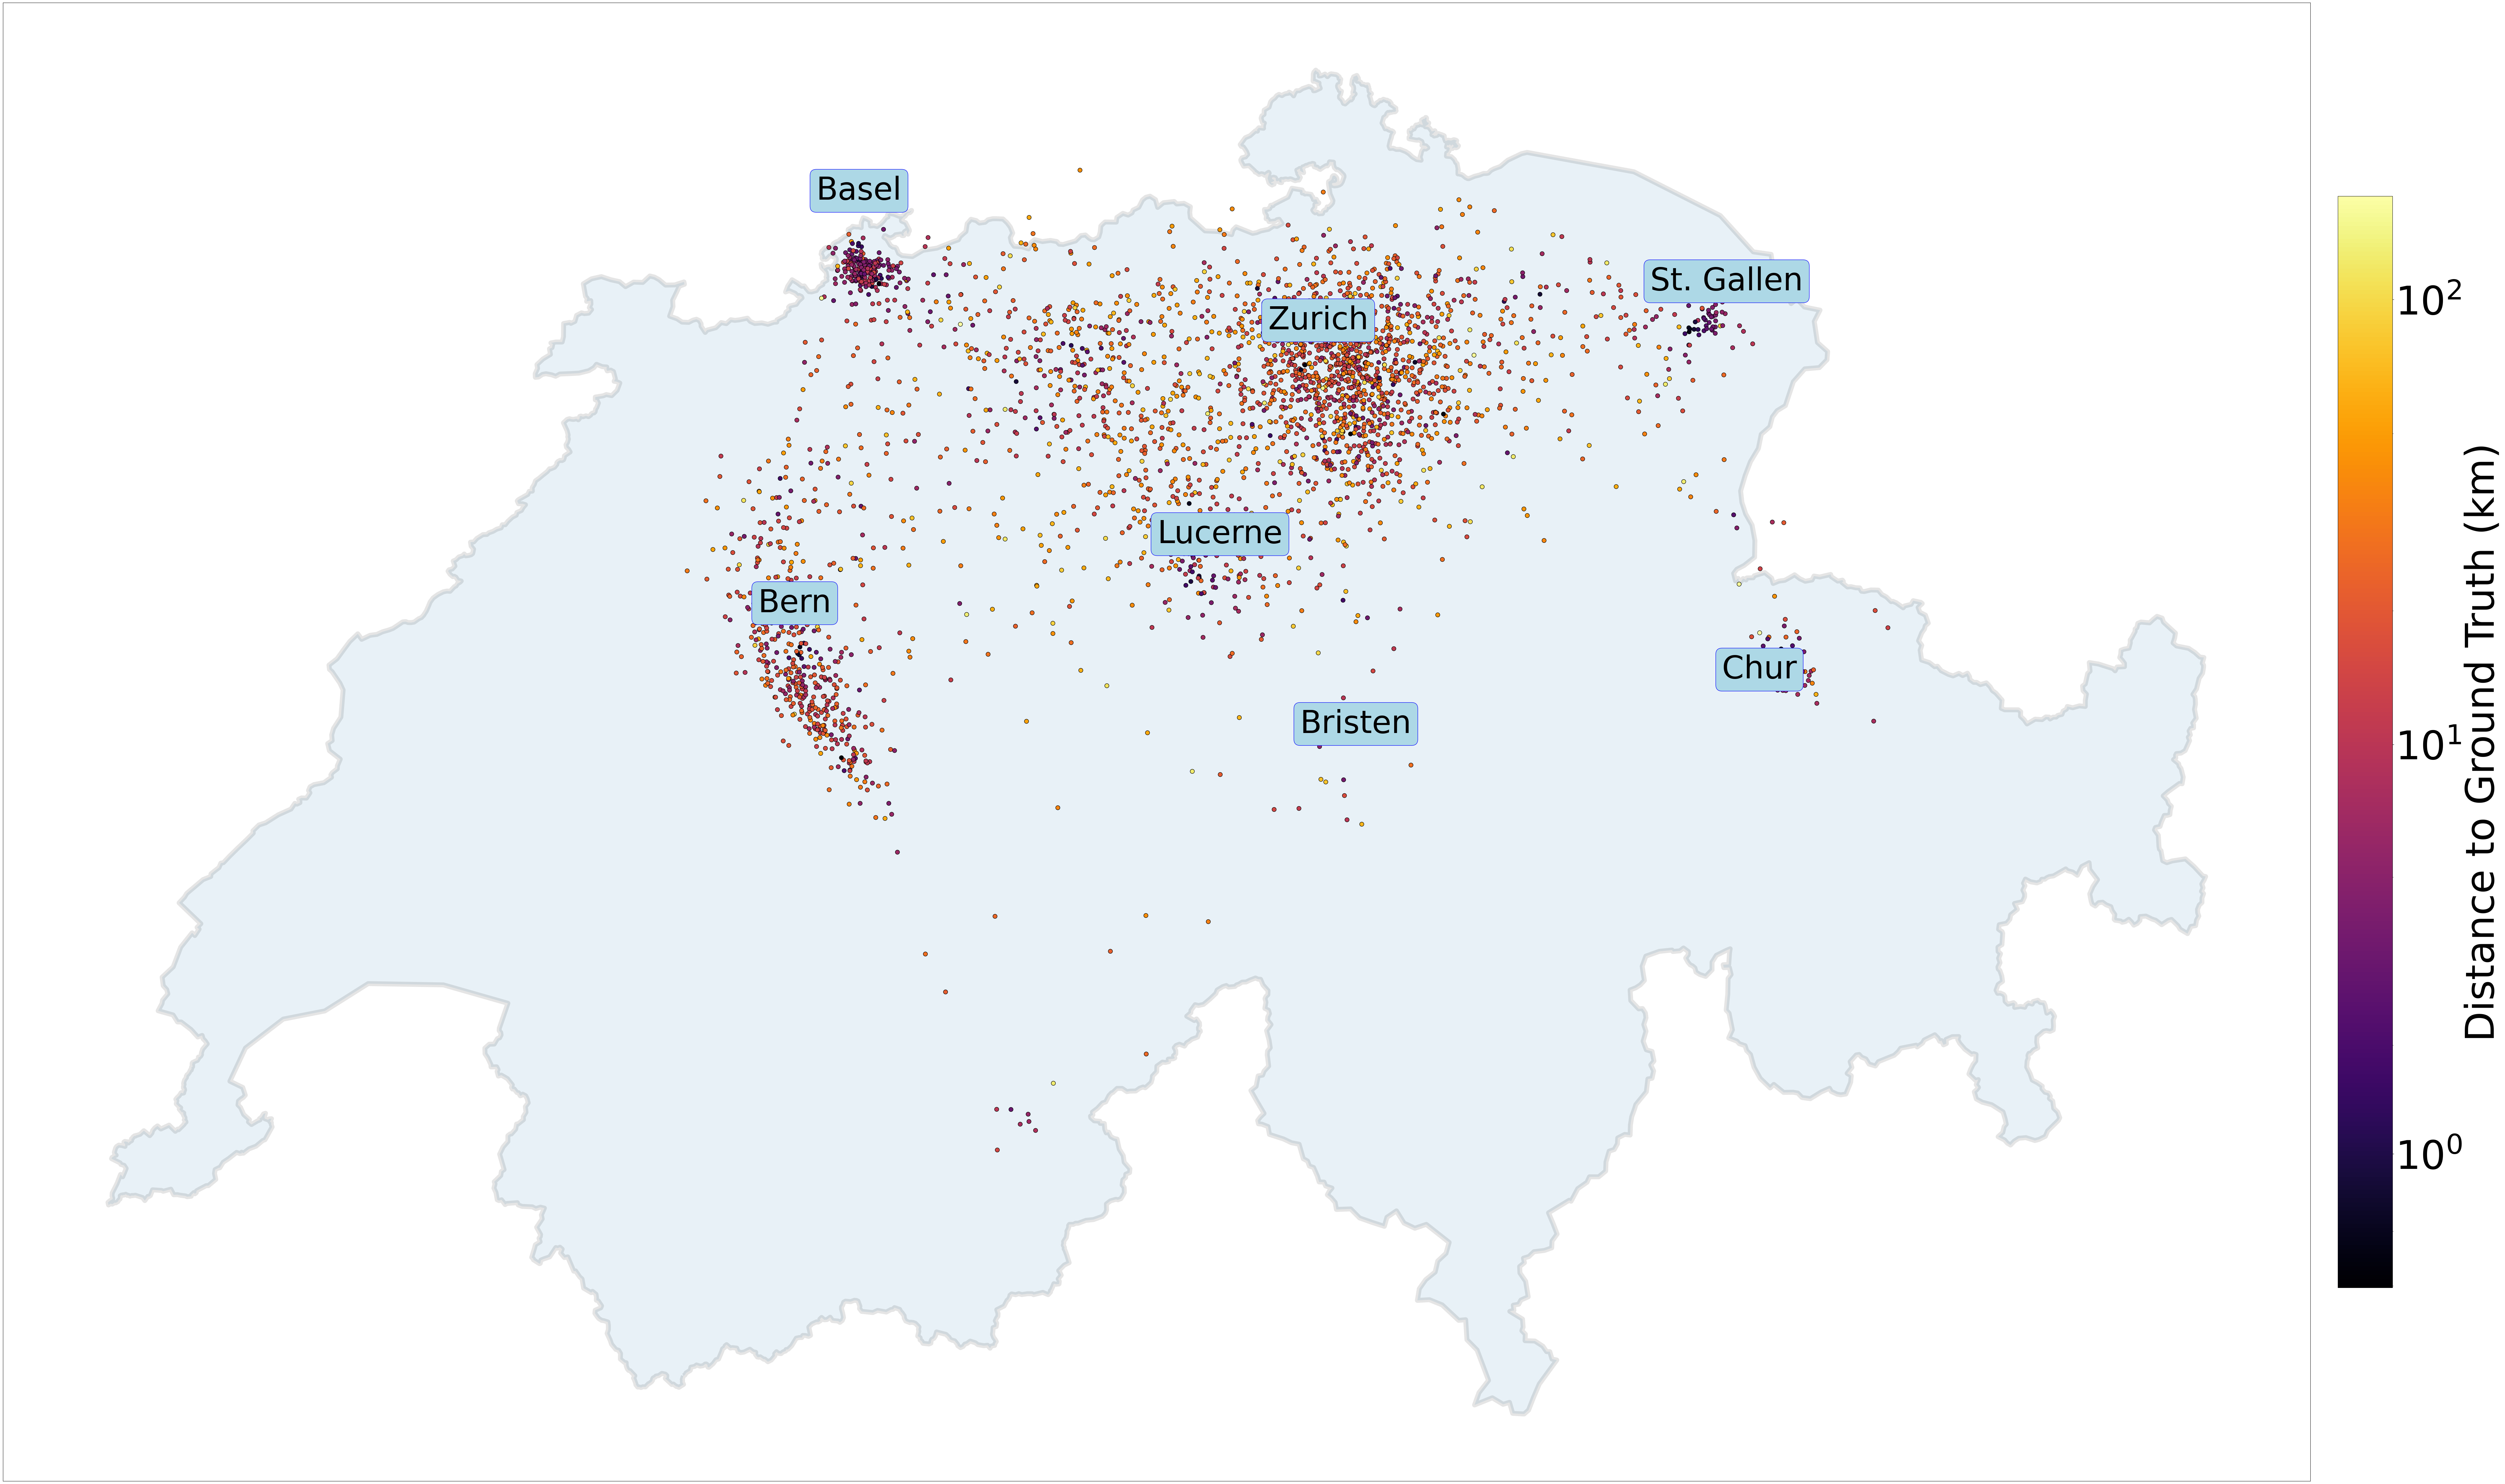

In [12]:
plot_switzerland(test_preds, test_gold_data, data_path)

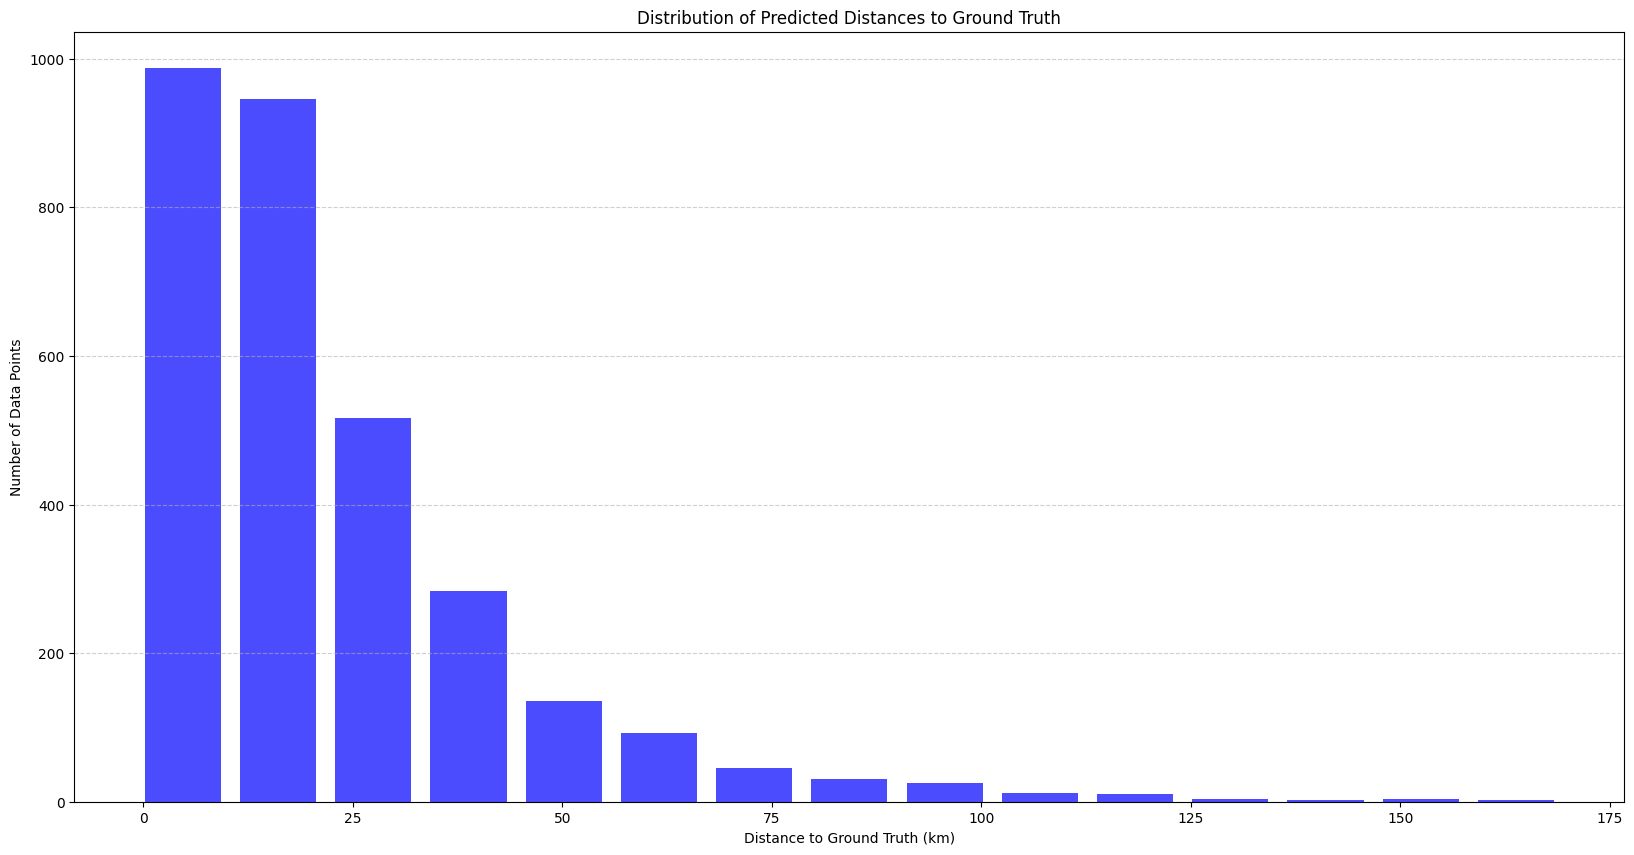

In [13]:
plot_barchart(test_preds, test_gold_data)